In [3]:
%load_ext autoreload
%autoreload 

from preprocessing.preprocess_ucr import UCRDatasetImporter
from preprocessing.preprocess_ucr import UCRDataset
from preprocessing.preprocess_ucr import AugUCRDataset
from preprocessing.data_pipeline import build_data_pipeline
from utils import load_yaml_param_settings

from utils import time_to_timefreq, timefreq_to_time
from preprocessing.augmentations import TimeFreqAugmenter, Augmenter
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
import torch.nn.functional as F
import math

/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


self.X_train.shape: (1000, 128)
self.X_test.shape: (4000, 128)
# unique labels (train): [0 1 2 3]
# unique labels (test): [0 1 2 3]


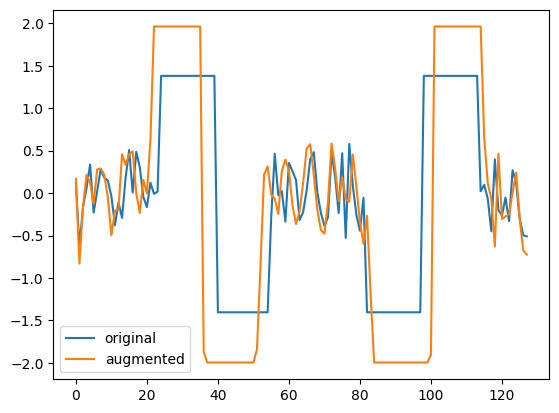

In [4]:
config = load_yaml_param_settings("configs/config.yaml")

dataset_name = "TwoPatterns"
config['dataset']['dataset_name'] = dataset_name

# data pipeline
dataset_importer = UCRDatasetImporter(**config["dataset"])
batch_size = config["dataset"]["batch_sizes"]["stage1"]
train_data_loader_aug = build_data_pipeline(
    batch_size, dataset_importer, config, "train", augment=True,
)
train_data_loader = build_data_pipeline(
    batch_size, dataset_importer, config, "train", augment=False
)

test_data_loader = build_data_pipeline(batch_size, dataset_importer, config, "test")

augmenter = TimeFreqAugmenter(**config["augmentations"]["aug_params"])
for batch in train_data_loader_aug:
    [x_original, xaug], y = batch
    break

plt.plot(x_original[0, 0], label="original")
plt.plot(xaug[0, 0], label="augmented")
plt.legend()
plt.savefig(dataset_name + "_augmentation.png")
plt.show()

In [5]:
from experiments.exp_vqvae import Exp_VQVAE
from utils import quantize
import torch.nn as nn
from einops import rearrange

input_length = train_data_loader.dataset.X.shape[-1]

config["SSL"]["stage1_method"] = ""
train_exp = Exp_VQVAE(
    input_length,
    config=config,
    n_train_samples=len(train_data_loader.dataset),
    train_data_loader=train_data_loader,
    test_data_loader=test_data_loader,
)
encoder = train_exp.encoder
vq_model = train_exp.vq_model

def encode_to_z_q(x, encoder, vq_model):
    """
    x: (B, C, L)
    """
    C = x.shape[1]
    xf = time_to_timefreq(x, 8, C)  # (B, C, H, W)
    z = encoder(xf)  # (b c h w)
    z_q, indices, vq_loss, perplexity = quantize(
        z, vq_model
    )  # (b c h w), (b (h w) h), ...
    return z_q, indices

In [7]:
# def generate_masks(emb, mask_emb, device="cpu", gamma=gamma_func()):
#     # randomly sample `t`
#     t = np.random.uniform(0, 1)

#     # create masks
#     n_masks = math.floor(gamma(t) * emb.shape[1])
#     rand = torch.rand(emb.shape, device=device)  # (b n)
#     mask = torch.zeros(emb.shape, dtype=torch.bool, device=device)
#     mask.scatter_(dim=1, index=rand.topk(n_masks, dim=1).indices, value=True)

#     # masked tokens
#     masked_indices = mask_emb * torch.ones_like(
#         emb, device=device
#     )  # (b n)
#     emb_M = mask * emb + (~mask) * masked_indices  # (b n); `~` reverses bool-typed data
#     return emb_M

def generate_masks(emb, mask_emb, device="cpu", gamma=gamma_func()):
    # randomly sample `t`
    t = np.random.uniform(0, 1)

    n_masks = math.floor(gamma(t) * emb.shape[1])
    print(n_masks)
    mask_indices = torch.rand(emb.shape[0], emb.shape[1], device=device).topk(n_masks, dim=1).indices
    
    mask = torch.zeros(emb.shape[0], emb.shape[1], dtype=torch.bool, device=device)
    mask.scatter_(1, mask_indices, True)

    # Apply masks
    emb_M = torch.where(mask.unsqueeze(-1), mask_emb, emb)  # use torch.where to select masked_emb or original

    return emb_M

dim = config["encoder"]["dim"]
mask_emb = nn.Parameter(torch.rand(dim, )) #(h, w, c)
zq, s = encode_to_z_q(x_original, encoder, vq_model) #zq has shape (b, c, h, w)
zq = rearrange(zq, "b c h w -> b (h w) c") #(b, h*w, c)
zq_M = generate_masks(zq, mask_emb) #returns shape with (b, h*w, c)



20


In [51]:
device = "cpu"
def gamma_func(mode="cosine"):
        if mode == "linear":
            return lambda r: 1 - r
        elif mode == "cosine":
            return lambda r: np.cos(r * np.pi / 2)
        elif mode == "square":
            return lambda r: 1 - r**2
        elif mode == "cubic":
            return lambda r: 1 - r**3
        else:
            raise NotImplementedError
        
gamma = gamma_func()
t = np.random.uniform(0, 1)
dim = 64
# create masks
n_masks = math.floor(gamma(t) * s.shape[1])
rand = torch.rand(s.shape, device=device)  # (b n)
mask = torch.zeros(s.shape, dtype=torch.bool, device=device)
mask.scatter_(dim=1, index=rand.topk(n_masks, dim=1).indices, value=True)

z_q, _ = encode_to_z_q(x_original, encoder, vq_model)  # (b n)
z_q = rearrange(z_q, "b c h w -> b (h w) c")  # (b, h*w, c)
mask_emb = nn.Parameter(torch.randn(dim, ))  # (c)

#mask_emb = mask_emb.view(1, 1, -1)  # reshape to (1, 1, c)
#z_q_M= torch.where(mask.unsqueeze(-1), mask_emb, z_q)  # apply the mask

In [9]:
print(n_masks)
print(torch.sum(z_q_M == mask_emb, dim=1))

14
tensor([[14, 14, 14,  ..., 14, 14, 14],
        [14, 14, 14,  ..., 14, 14, 14],
        [14, 14, 14,  ..., 14, 14, 14],
        ...,
        [14, 14, 14,  ..., 14, 14, 14],
        [14, 14, 14,  ..., 14, 14, 14],
        [14, 14, 14,  ..., 14, 14, 14]])


In [10]:
from experiments.exp_full_embed_maskgit import ExpFullEmbedMaskGIT
config["SSL"]["stage1_method"] = "vibcreg"
train_exp = ExpFullEmbedMaskGIT(
            input_length, config, len(train_data_loader.dataset), n_classes=len(np.unique(train_data_loader.dataset.Y))
)


/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
vibcreg_encoder-TwoPatterns.ckpt
vibcreg encoder loaded
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
vibcreg_decoder-TwoPatterns.ckpt
vibcreg decoder loaded
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
vibcreg_vqmodel-TwoPatterns.ckpt
vibcreg vqmodel loaded


In [11]:
maskgit = train_exp.maskgit

logits, target = maskgit(x_original, y)

sampled_ids = torch.distributions.categorical.Categorical(
                logits=logits
).sample()  # (b n)

In [12]:
sampled_embs = vq_model.project_out(F.embedding(sampled_ids, vq_model._codebook.embed))
unknown_map = z_q_M == mask_emb
sampled_embs = torch.where(unknown_map, sampled_embs, z_q)

probs = F.softmax(logits, dim=-1)
selected_probs = torch.gather(
    probs, dim=-1, index=sampled_embs.unsqueeze(-1)
).squeeze()


RuntimeError: gather(): Expected dtype int64 for index

In [14]:
num = 1
num_embeddings = 70

masked_embeddings =  mask_emb.repeat(num, num_embeddings, 1)

masked_embeddings.shape

torch.Size([1, 70, 64])

In [26]:


s

quantize = vq_model.project_out(F.embedding(s, vq_model._codebook.embed))
quantize.shape
print(encoder.H_prime * encoder.W_prime)

tensor([40], dtype=torch.int32)


In [28]:
print(s.shape, z_q.shape)
z_q = rearrange(z_q, "b c h w -> b (h w) c")
print(z_q.shape)

torch.Size([128, 40]) torch.Size([128, 64, 5, 8])
torch.Size([128, 40, 64])


In [153]:
t = np.random.uniform(0, 1)
mask_token_ids = 32
# create masks
n_masks = math.floor(gamma(t) * s.shape[1])
rand = torch.rand(s.shape, device=device)  # (b n)
mask = torch.zeros(s.shape, dtype=torch.bool, device=device)
mask.scatter_(dim=1, index=rand.topk(n_masks, dim=1).indices, value=True)

# masked tokens
masked_indices = mask_token_ids * torch.ones_like(
    s, device=device
)  # (b n)
s_M = ~mask * s + (mask) * masked_indices  # (b n); `~` reverses bool-typed data
print(n_masks)
print(torch.sum(s_M == mask_token_ids, dim=1))

36
tensor([36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
        36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
        36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
        36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
        36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
        36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
        36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
        36, 36])


In [155]:
def s_to_z_q(s, vq_model, mask_token_ids, mask_emb):
    # s: (b, n) containing masked tokens
    # z_q : (b, n, d)
    unmasked_map = ~(s == mask_token_ids)  # b n
    unmasked_s = s[unmasked_map].reshape(s.shape[0], -1)  # b n_unmasked
    unmasked_z_q = vq_model.project_out(
        F.embedding(unmasked_s, vq_model._codebook.embed)
    )  # b n_unmasked d. Unmasked z_q's

    blank_z_q = mask_emb.repeat(
        unmasked_map.size(0), unmasked_map.size(1), 1
    )  # blank z_q

    unmasked_map = unmasked_map.unsqueeze(-1).repeat(
        1, 1, mask_emb.size(-1)
    )  # -> b n d

    unmasked_indices = unmasked_map.nonzero(
        as_tuple=True
    )  # now indices are (b n d) to z_q

    z_q = blank_z_q.clone()

    # Assign unmasked_z_q to z_q at the unmasked_indices
    z_q[unmasked_indices] = unmasked_z_q

    return z_q

In [156]:


z_q_M = s_to_z_q(s_M, vq_model)

RuntimeError: shape mismatch: value tensor of shape [128, 4, 64] cannot be broadcast to indexing result of shape [32768]

In [157]:
unmasked_map = ~(s_M == mask_token_ids) # b n
unmasked_s = s[unmasked_map].reshape(s.shape[0], -1) # b n_unmasked

unmasked_embs = vq_model.project_out(F.embedding(unmasked_s, vq_model._codebook.embed)) # b n_unmasked d

mask_embs = mask_emb.repeat(unmasked_map.size(0), unmasked_map.size(1), 1)

#expand unmasked map to 3D
unmasked_map = unmasked_map.unsqueeze(-1).repeat(1, 1, mask_emb.size(-1))

# Get the indices of the unmasked locations
unmasked_indices = unmasked_map.nonzero(as_tuple=True)

# Create a tensor of the same shape as mask_embs
filled_mask_embs = mask_embs.clone()

# Calculate the total number of elements in unmasked_embs
num_elements = unmasked_embs.numel()

# Reshape unmasked_embs into a 1D tensor with num_elements elements
unmasked_embs_1d = unmasked_embs.view(num_elements)

# Fill in the unmasked_embs at the unmasked locations
filled_mask_embs[unmasked_indices] = unmasked_embs_1d

print(torch.sum(filled_mask_embs == mask_emb, dim=1))

tensor([[36, 36, 36,  ..., 36, 36, 36],
        [36, 36, 36,  ..., 36, 36, 36],
        [36, 36, 36,  ..., 36, 36, 36],
        ...,
        [36, 36, 36,  ..., 36, 36, 36],
        [36, 36, 36,  ..., 36, 36, 36],
        [36, 36, 36,  ..., 36, 36, 36]])


In [151]:
# Get the embeddings at the unmasked locations in filled_mask_embs
unmasked_embs_in_filled_mask_embs = filled_mask_embs[unmasked_indices]

# Reshape unmasked_embs_in_filled_mask_embs to match the shape of unmasked_embs
unmasked_embs_in_filled_mask_embs = unmasked_embs_in_filled_mask_embs.view(unmasked_embs.shape)

# Check if unmasked_embs_in_filled_mask_embs is equal to unmasked_embs
is_equal = torch.all(torch.eq(unmasked_embs_in_filled_mask_embs, unmasked_embs))

print(is_equal)  # Should print: tensor(True)

tensor(True)
